In [3]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 
data = torch.load('data/eit-circles-dataset-128.pt')

train_min = data["train"].min()
train_max = data["train"].max()


gt = data["test"][5].cpu()


cwd = /home/johnma/flow-inverse


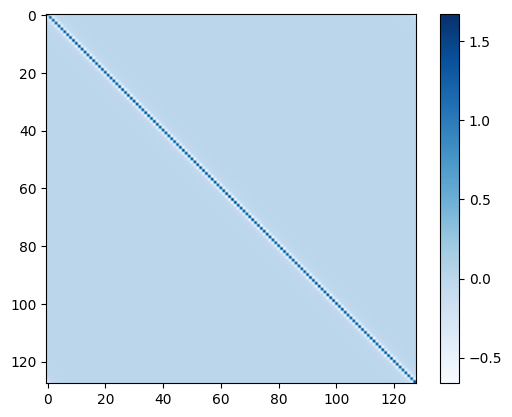

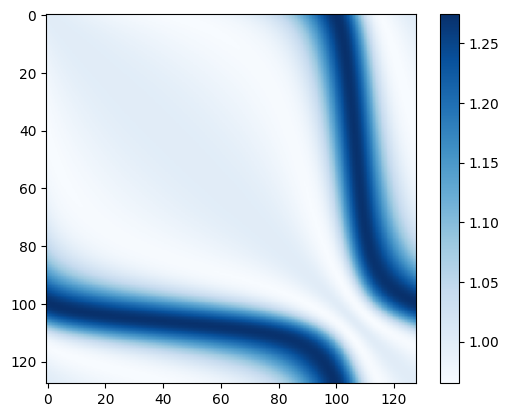

In [9]:
import random 
# load mesh
data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
img_size = 128
original_size = 128
pad_size = 0

gt = data["test"][random.randint(0, len(data["test"]))].cpu()
# gt = data["test"][5].cpu()

mat_fname  = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

# get the dtn map
dtn_map_before = dtn_from_sigma(sigma_vec=gt, v_h=v_h, mesh=mesh, img_size=img_size, device=device)
dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device)
dtn_map = dtn_map_before / dtn_background
# dtn_map = torch.log(dtn_map)

plt.imshow(dtn_map_before.reshape((128, 128)).cpu().detach().numpy(), cmap='Blues')
plt.colorbar()


plt.figure()
plt.imshow(dtn_map.reshape((128, 128)).cpu().detach().numpy(), cmap='Blues')
plt.colorbar()


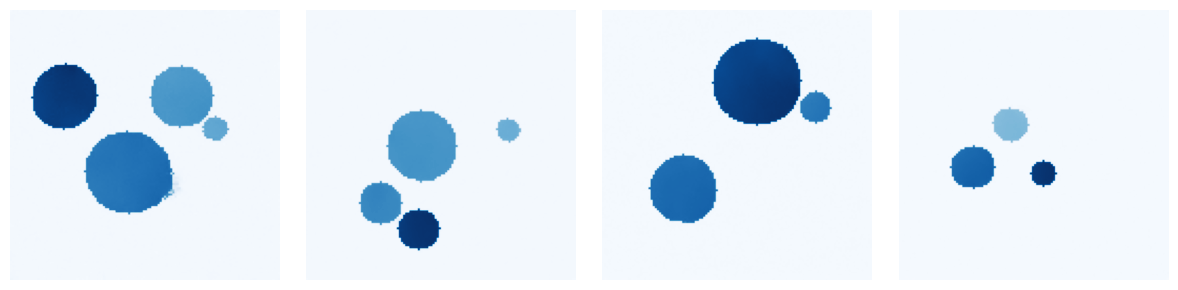

In [278]:
model = Unet(ch=32).to(device)
checkpoint = torch.load("saved_runs/circles-eit-v-pred-ones-to-circs/checkpoints/ckp_31500.tar", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
x0 = torch.ones(4, 1, 128, 128).to(device)
x0 = x0 + 0.1*torch.randn_like(x0)

def v_field(z, t):
    t_batch = t.expand(z.shape[0])
    return model(z, t_batch)

timesteps = torch.linspace(0.0, 1.0, steps=5).to(device)
with torch.no_grad():
    pred = odeint(
        func=lambda t, x: v_field(x, t),
        t=timesteps,
        y0=x0,
        method='dopri5',
        atol=1e-5,
        rtol=1e-5,
    )[-1]

# Unnormalize predictions
pred = 0.5 * (pred + 1.0) * (train_max - train_min) + train_min

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    img = pred[i].squeeze().cpu().numpy()
    axes[i].imshow(img, cmap="Blues")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [282]:
# sparsity regularized loss_fn
loss_fn = torch.nn.MSELoss() 
SIGMA_MIN = 1e-2
N = 100
gt = gt.squeeze()
t = torch.linspace(0., 1-SIGMA_MIN, N).to(device)
gamma = 1e-5
xi = torch.ones(img_size, img_size).to(device)
xi += 0.1*torch.randn(img_size, img_size).to(device)
xn_trajectory = []
Fx_trajectory = []
pbar = tqdm(range(N), desc='PnP solver iterating')
for i in pbar:
    xi = xi.requires_grad_()
    Fx = dtn_from_sigma(xi, v_h, mesh, img_size, device).squeeze(0).squeeze(0)
    Fx /= dtn_background
    Fx = torch.clamp(Fx, min=1e-6)
    Fx = torch.log(Fx)
    grad = torch.autograd.grad(loss_fn(Fx, dtn_map), xi)[0]
    pbar.set_postfix({'data-fidelity': loss_fn(Fx, gt).item(), 'grad-norm': grad.norm().item()})
    lr_t = (1 - t[i])**gamma
    zi = xi - lr_t * grad
    eps = torch.ones(1,1,img_size,img_size).to(device) + 0.1*torch.randn(1, 1, img_size, img_size).to(device) 
    zi_tilde = (1-t[i])*eps + t[i]*zi
    with torch.no_grad():
        # normalize
        zi_tilde_normalized = 2.0 * (zi_tilde - train_min) / (train_max - train_min) - 1.0
        model_output = model(zi_tilde_normalized, torch.tensor([t[i]]).to(device))
        # unnormalize 
        model_output = 0.5 * (model_output + 1.0) * (train_max - train_min) + train_min
        xi = zi_tilde + (1-t[i])*model_output
    xn_trajectory.append(xi.detach().cpu().squeeze(0).squeeze(0).numpy())
    Fx_trajectory.append(Fx.detach().cpu().squeeze(0).squeeze(0).numpy())


PnP solver iterating: 100%|██████████| 100/100 [00:03<00:00, 26.29it/s, data-fidelity=12.1, grad-norm=0.656] 


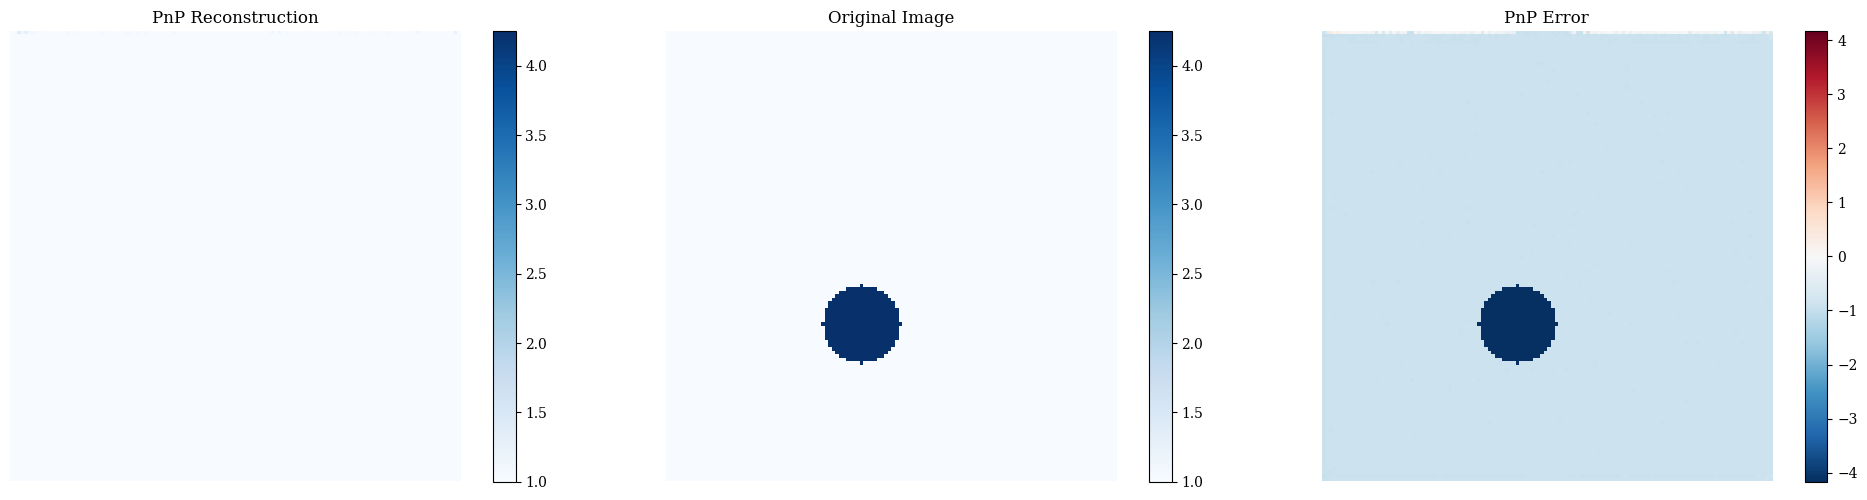

In [283]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams["font.family"] = "DejaVu Serif"
title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

im1 = axes[0].imshow(xi.squeeze().detach().cpu().numpy(), cmap="Blues", vmin=gt.squeeze().cpu().numpy().min(), vmax=gt.squeeze().cpu().numpy().max())
axes[0].set_title('PnP Reconstruction')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])


im3 = axes[1].imshow(gt.squeeze().cpu().numpy(), cmap="Blues", vmin=gt.squeeze().cpu().numpy().min(), vmax=gt.squeeze().cpu().numpy().max())
axes[1].set_title('Original Image')
axes[1].axis('off')
plt.colorbar(im3, ax=axes[1])

error = xi.squeeze().detach().cpu().numpy() - gt.squeeze().cpu().numpy()
im4 = axes[2].imshow(error, cmap='RdBu_r', vmin=-np.abs(error).max(), vmax=np.abs(error).max())
axes[2].set_title('PnP Error')
axes[2].axis('off')
plt.colorbar(im4, ax=axes[2])

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

gt_img = gt.squeeze().cpu().numpy()

def animate_comparison(frame):
    ax1.clear()
    ax2.clear() 
    ax3.clear()
    ax4.clear()

    current_img = xn_trajectory[frame].squeeze()
    current_dtn = Fx_trajectory[frame].squeeze()
    
    im1 = ax1.imshow(current_img, cmap="Blues", vmin=gt_img.min(), vmax=gt_img.max())
    ax1.set_title(f'Reconstruction - Step {frame}', fontsize=12)
    ax1.axis('off')

    
    im2 = ax2.imshow(gt_img, cmap="Blues", vmin=gt_img.min(), vmax=gt_img.max())
    ax2.set_title('Ground Truth', fontsize=12)
    ax2.axis('off')
    
    diff = current_img - gt_img
    im3 = ax3.imshow(diff, cmap='RdBu_r', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
    ax3.set_title(f'Difference', fontsize=12)
    ax3.axis('off')

    im4 = ax4.imshow(current_dtn.reshape((128, 128)), cmap="Blues")
    ax4.set_title('DtN', fontsize=12)
    ax4.axis('off')
    
    return [im1, im2, im3, im4]

frame_indices = list(range(0, len(xn_trajectory), max(1, len(xn_trajectory) // 100)))
anim_comparison = animation.FuncAnimation(fig, animate_comparison, frames=frame_indices, 
                                        interval=300, blit=False, repeat=True)

plt.close(fig)  

html_comparison = HTML(anim_comparison.to_jshtml())
html_comparison